c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


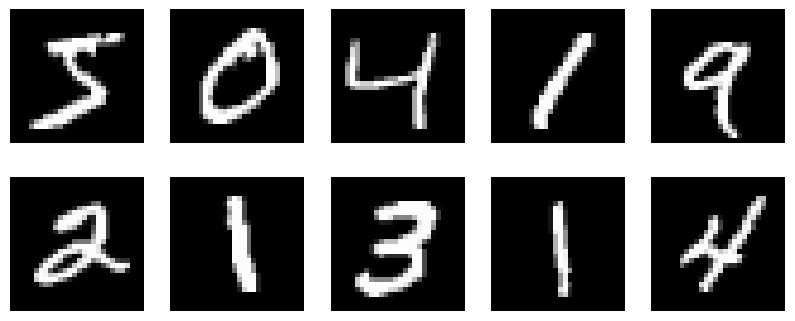

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca


# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [2]:
import torch as th
from tqdm.auto import trange
device = "cuda" if th.cuda.is_available() else "cpu"
from src.ppca import ppca_closed_form, mppca

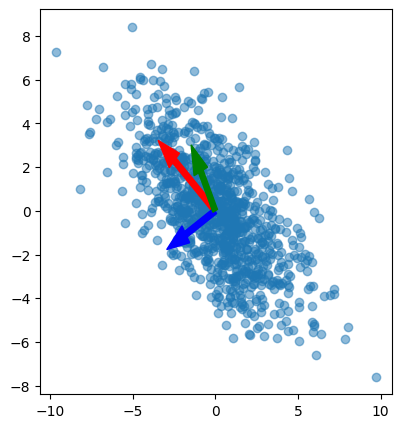

In [3]:
import torch as th
import numpy as np
from src.ppca import ppca_closed_form, device

def test_ppca_synthetic():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data
    n_samples = 1000  # number of samples
    d = 10           # observed dimensions
    q = 3            # latent dimensions
    
    # Create true parameters
    W_true = th.randn(d, q).to(device)  # true weight matrix
    z = th.randn(n_samples, q).to(device)  # latent variables
    noise = 0.1 * th.randn(n_samples, d).to(device)  # observation noise
    
    # Generate observations
    X = z @ W_true.T + noise
    
    # Run PPCA
    W_estimated = ppca_closed_form(X, q)
    
    # Since PPCA is invariant to rotations, we need to compare the subspaces
    # rather than the exact matrices
    
    # Compare subspaces using principal angles
    U1 = th.linalg.qr(W_true)[0]
    U2 = th.linalg.qr(W_estimated)[0]
    
   # visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), alpha=0.5, label='Data Points')
    # add principal components
    plt.arrow(0, 0, U2[0, 0].cpu().numpy() * 5, U2[1, 0].cpu().numpy() * 5, color='red', width=0.3)
    plt.arrow(0, 0, U2[0, 1].cpu().numpy() * 5, U2[1, 1].cpu().numpy() * 5, color='blue', width=0.3)
    plt.arrow(0, 0, U2[0, 2].cpu().numpy() * 5, U2[1, 2].cpu().numpy() * 5, color='green', width=0.3)
    plt.show()

test_ppca_synthetic()

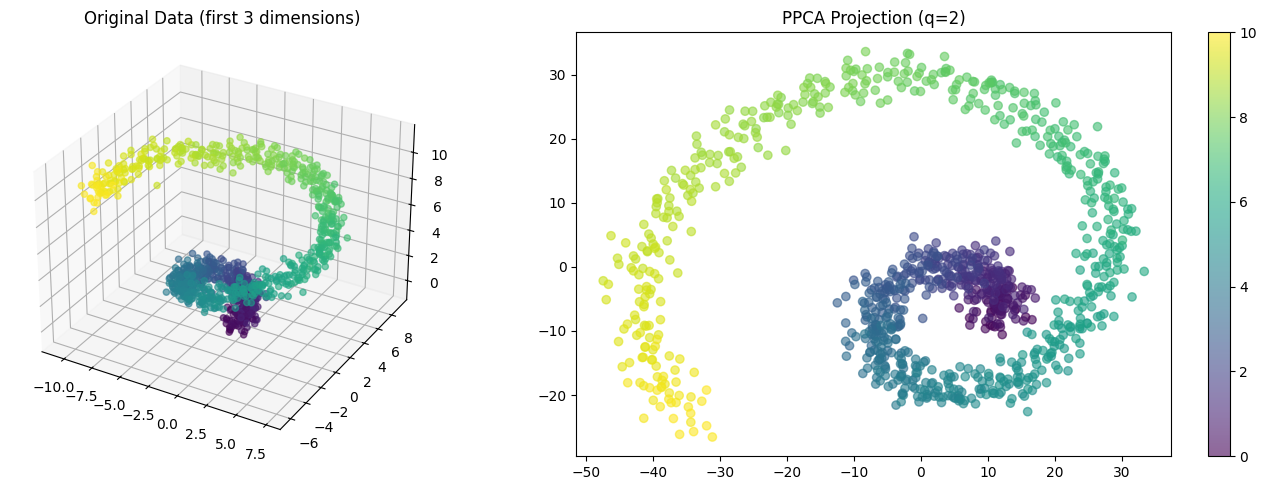

In [4]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form

def visual_test_ppca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions to make it more interesting
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data
    X_centered = X - X.mean(dim=0)
    X_projected = X_centered @ W
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(121, projection='3d')
    ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax1.set_title('Original Data (first 3 dimensions)')
    
    # PPCA projection
    ax2 = plt.subplot(122)
    scatter = ax2.scatter(X_projected[:, 0].cpu().numpy(), X_projected[:, 1].cpu().numpy(),
                         c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax2.set_title('PPCA Projection (q=2)')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

visual_test_ppca()

  8%|▊         | 8/100 [00:00<00:00, 104.17it/s]
C:\Users\ConnardMcGregoire\AppData\Local\Temp\ipykernel_8160\2287443407.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Finished in 8 iterations with update size 5.45931763943527e-05


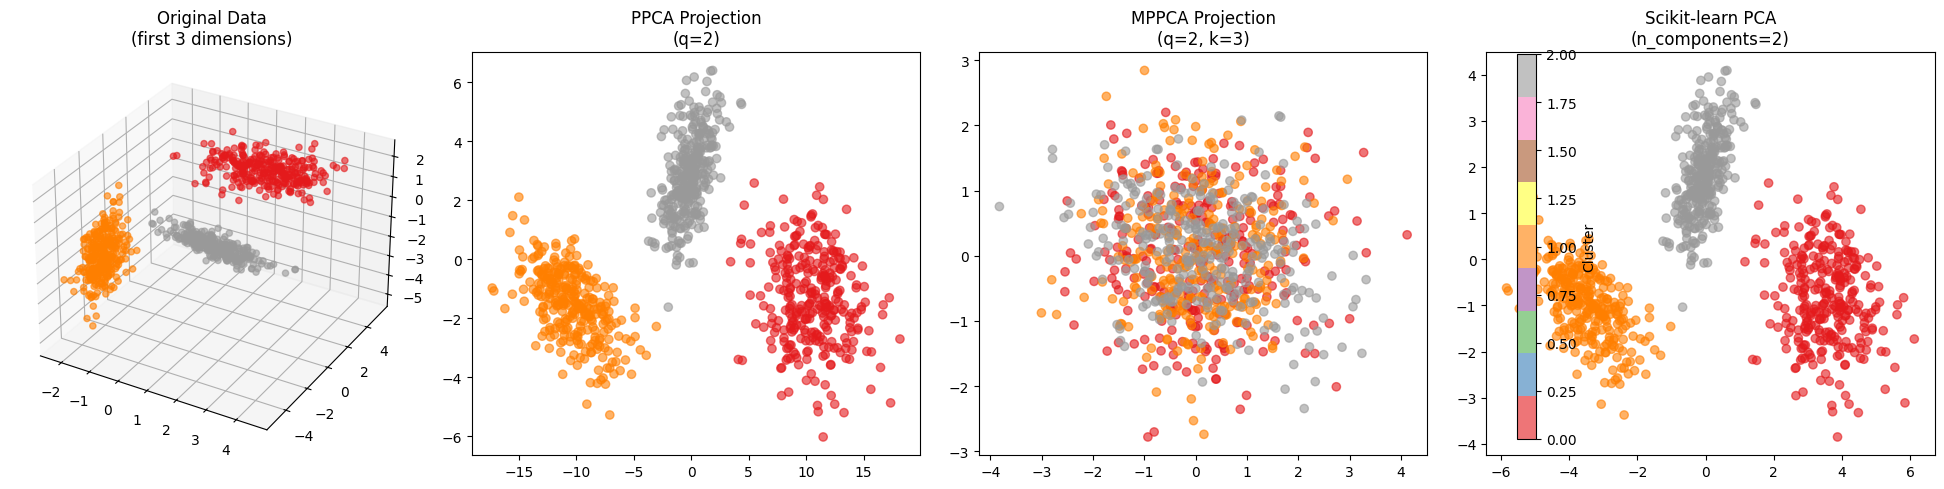

PCA explained variance ratio: [0.73811007 0.20541097]


In [5]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form, mppca
from sklearn.decomposition import PCA
device = "cuda" if th.cuda.is_available() else "cpu"
def test_mppca_visual():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with multiple clusters
    n_samples_per_cluster = 300
    n_clusters = 3
    n_samples = n_samples_per_cluster * n_clusters
    
    # Create clusters in 3D with different orientations
    clusters = []
    colors = []
    
    # Cluster 1: Horizontal plane with some noise
    z1 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    xy1 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0]).to(device)
    clusters.append(cluster1)
    colors.extend([0] * n_samples_per_cluster)
    
    # Cluster 2: Vertical plane with some noise
    x2 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    yz2 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0]).to(device)
    clusters.append(cluster2)
    colors.extend([1] * n_samples_per_cluster)
    
    # Cluster 3: Diagonal plane with some noise
    points = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    noise = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    rotation = th.tensor([[1.0, -1.0, 1.0], 
                         [1.0, 1.0, -1.0], 
                         [-1.0, 1.0, 1.0]]).to(device) / np.sqrt(3)
    cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0]).to(device)
    clusters.append(cluster3)
    colors.extend([2] * n_samples_per_cluster)
    
    # Combine all clusters
    X = th.cat(clusters, dim=0)
    colors = th.tensor(colors).to(device)
    
    # Add two extra noisy dimensions
    X = th.cat([X, 0.1 * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA, MPPCA and PCA
    W_ppca = ppca_closed_form(X, q=2)
    W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=2, k=3)
    pca = PCA(n_components=2)
    
    # Project the data
    X_centered_ppca = X - X.mean(dim=0)
    X_ppca = X_centered_ppca @ W_ppca
    
    # For MPPCA, project using the closest component
    distances = []
    for i in range(3):
        diff = X - mu_mppca[i].unsqueeze(0)
        distances.append(th.sum(diff * diff, dim=1))
    closest_component = th.stack(distances).argmin(dim=0)
    
    X_mppca = th.zeros_like(X_ppca, dtype=th.double)
    for i in range(3):
        mask = (closest_component == i)
        X_centered_mppca = X[mask] - mu_mppca[i].unsqueeze(0)
        X_mppca[mask] = X_centered_mppca @ W_mppca[i]
    
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    fig = plt.figure(figsize=(20, 5))
    
    # Original 3D data
    ax1 = fig.add_subplot(141, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax1.set_title('Original Data\n(first 3 dimensions)')
    
    # PPCA projection
    ax2 = fig.add_subplot(142)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax2.set_title('PPCA Projection\n(q=2)')
    
    # MPPCA projection
    ax3 = fig.add_subplot(143)
    scatter3 = ax3.scatter(X_mppca[:, 0].cpu().numpy(), X_mppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax3.set_title('MPPCA Projection\n(q=2, k=3)')
    
    # PCA projection
    ax4 = fig.add_subplot(144)
    scatter4 = ax4.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax4.set_title('Scikit-learn PCA\n(n_components=2)')
    
    # Add a single colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3, ax4], label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

if __name__ == "__main__":
    test_mppca_visual()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  9%|▉         | 9/100 [00:00<00:03, 28.96it/s]


Finished in 9 iterations with update size 2.732755758863966e-05


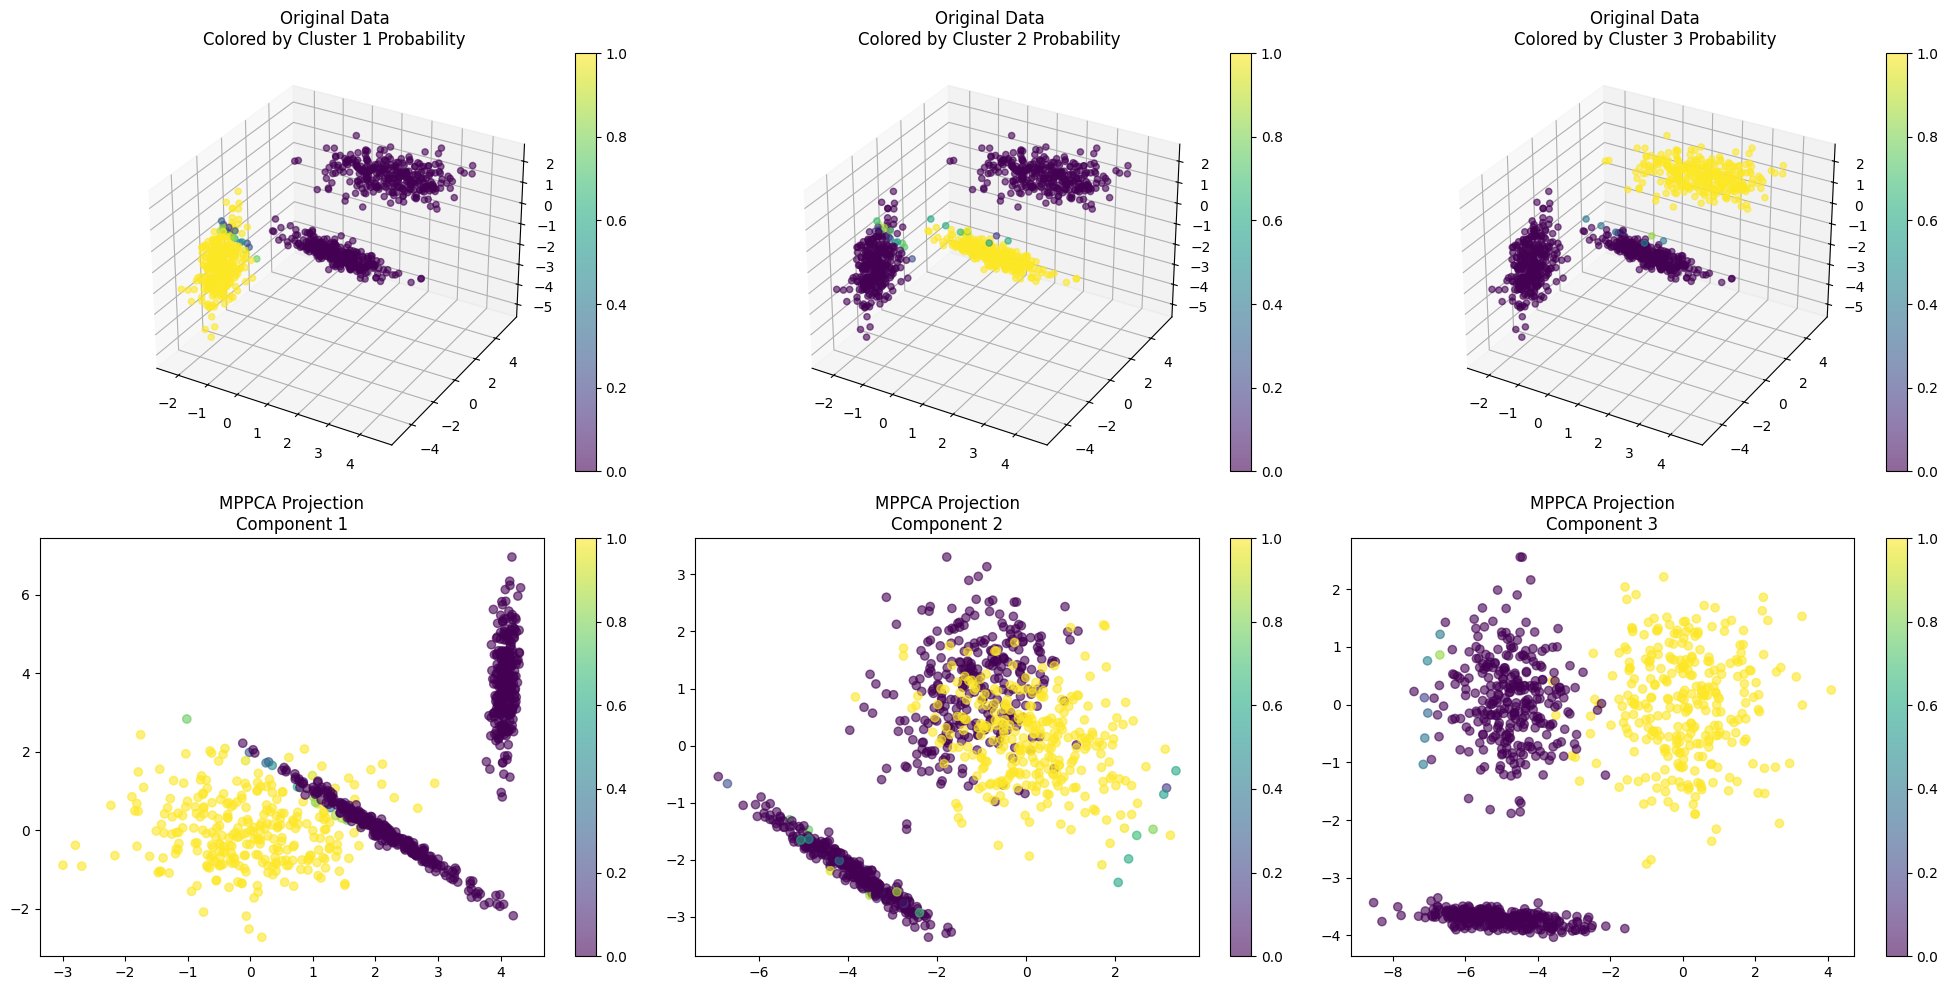

Mixing coefficients: [0.32259283 0.34068257 0.3367246 ]


In [8]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca, compute_Z, compute_responsibilities

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)

# Generate synthetic data with multiple clusters
n_samples_per_cluster = 300
n_clusters = 3
n_samples = n_samples_per_cluster * n_clusters

# Create clusters in 3D with different orientations
clusters = []

# Cluster 1: Horizontal plane with some noise
z1 = th.randn(n_samples_per_cluster, 1) * 0.1
xy1 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0])
clusters.append(cluster1)

# Cluster 2: Vertical plane with some noise
x2 = th.randn(n_samples_per_cluster, 1) * 0.1
yz2 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0])
clusters.append(cluster2)

# Cluster 3: Diagonal plane with some noise
points = th.randn(n_samples_per_cluster, 2) * 1.0
noise = th.randn(n_samples_per_cluster, 1) * 0.1
rotation = th.tensor([[1.0, -1.0, 1.0], 
                        [1.0, 1.0, -1.0], 
                        [-1.0, 1.0, 1.0]]) / np.sqrt(3)
cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0])
clusters.append(cluster3)

# Combine all clusters
X = th.cat(clusters, dim=0).to(device)

# Add two extra noisy dimensions
X = th.cat([X, 0.1 * th.randn(n_samples, 2, device=device)], dim=1)

# Run MPPCA
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=2, k=3)

# Calculate responsibilities using the same code as in mppca implementation
n, d = X.shape
k = W_mppca.shape[0]
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q=2, device=device)
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device)


# Project data for each component
X_mppca = th.zeros(k, n, 2, device=device)
for j in range(k):
    X_centered = X - mu_mppca[j].unsqueeze(0)
    X_mppca[j] = X_centered @ W_mppca[j]

# Plotting
fig = plt.figure(figsize=(20, 10))

# Original 3D data with probabilities for each cluster
for j in range(k):
    # Original data
    ax1 = fig.add_subplot(2, k, j+1, projection='3d')
    scatter1 = ax1.scatter(X.cpu()[:, 0], X.cpu()[:, 1], X.cpu()[:, 2], 
                            c=responsibilities[j].cpu(), 
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax1.set_title(f'Original Data\nColored by Cluster {j+1} Probability')
    plt.colorbar(scatter1, ax=ax1)
    
    # MPPCA projection
    ax2 = fig.add_subplot(2, k, j+k+1)
    scatter2 = ax2.scatter(X_mppca[j].cpu()[:, 0], X_mppca[j].cpu()[:, 1],
                            c=responsibilities[j].cpu(),
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax2.set_title(f'MPPCA Projection\nComponent {j+1}')
    plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# Print the mixing coefficients (proportion of points assigned to each cluster)
print("Mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 4 iterations with update size 1.5918804446599536e-05
....................................................................................................

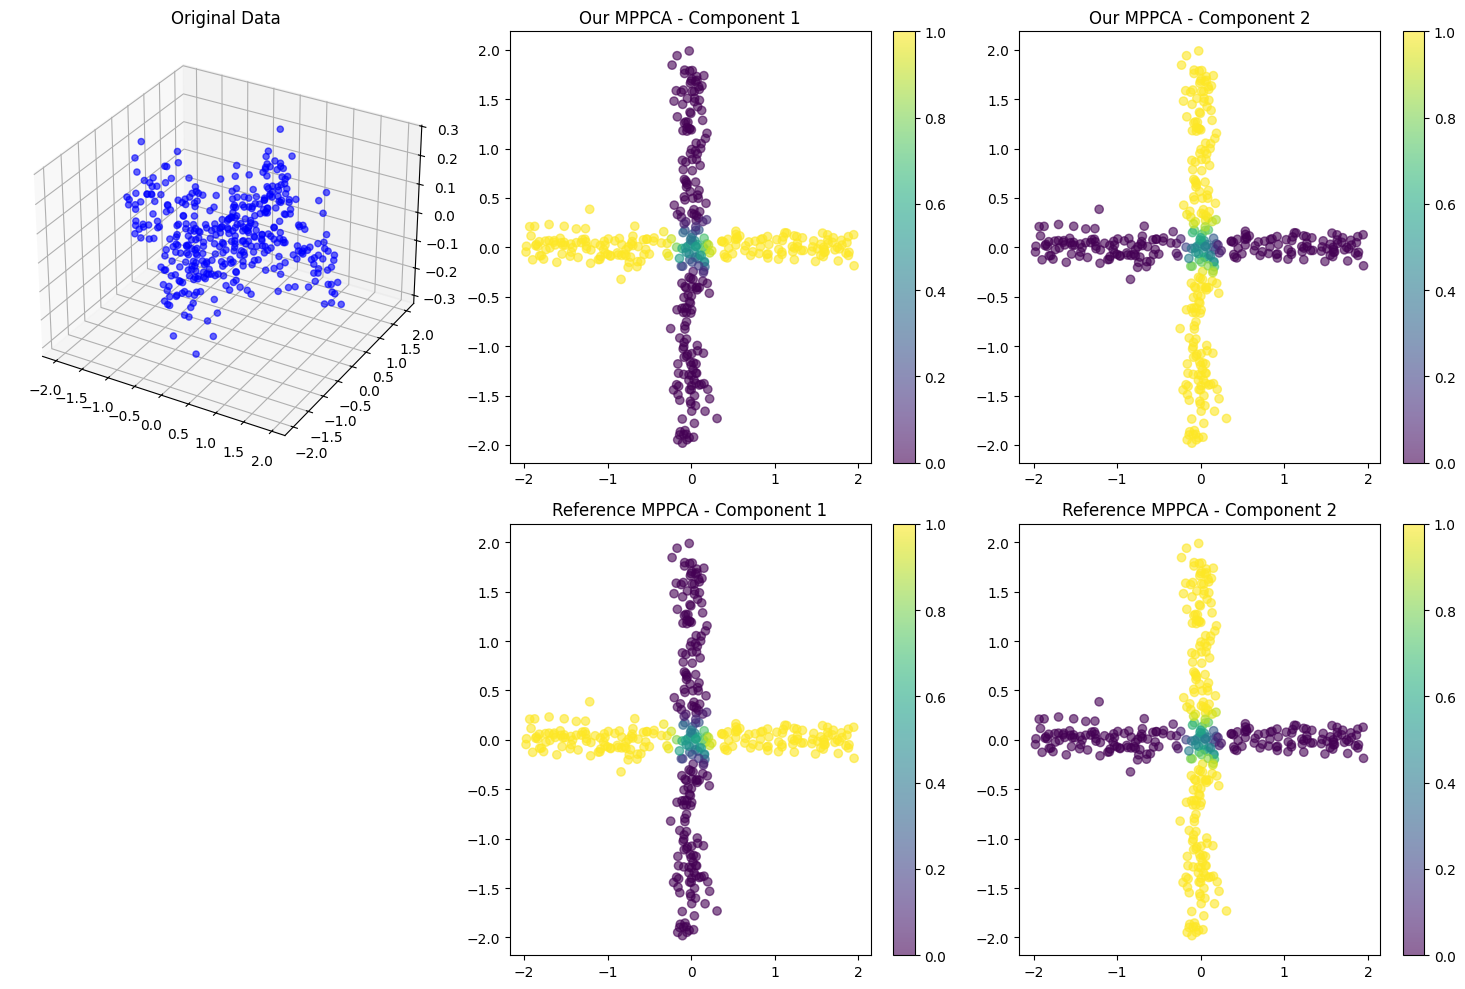

Our MPPCA mixing coefficients: [0.496787 0.503213]
Reference MPPCA mixing coefficients: [0.49704103 0.50295897]


In [ ]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca, compute_Z, compute_responsibilities
from ref import initialization_kmeans, mppca_gem

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)
q = 1
k = 2
use_kmeans_init = True
# Generate cross-shaped data
n_samples_per_arm = 200
noise = 0.1

# Horizontal arm
x1 = np.random.uniform(-2, 2, n_samples_per_arm)
y1 = np.random.normal(0, noise, n_samples_per_arm)

# Vertical arm
x2 = np.random.normal(0, noise, n_samples_per_arm)
y2 = np.random.uniform(-2, 2, n_samples_per_arm)

# Combine the arms
X_np = np.vstack([
    np.column_stack([x1, y1]),
    np.column_stack([x2, y2])
])

# Add a third noisy dimension
X_np = np.column_stack([X_np, np.random.normal(0, noise, X_np.shape[0])])

# Convert to torch tensor
X = th.tensor(X_np, dtype=th.float32).to(device)

# Run our MPPCA implementation
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k, use_kmeans_init=use_kmeans_init)

# Calculate responsibilities for our implementation
n, d = X.shape
k = W_mppca.shape[0]

M = W_mppca.transpose(1, 2) @ W_mppca + sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(2, device=device).unsqueeze(0)
M_inv = M.inverse()
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q, device)

mu_normals = th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1)
sigma_normals = sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(d, device=device)

# Calculate log responsibilities for numerical stability
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device)

# Run reference implementation
pi_ref, mu_ref, W_ref, sigma2_ref, clusters_ref = initialization_kmeans(X_np, k, q)
pi_ref, mu_ref, W_ref, sigma2_ref, R_ref, L_ref, sigma2hist_ref = mppca_gem(X_np, pi_ref, mu_ref, W_ref, sigma2_ref, 100)

# Plotting
fig = plt.figure(figsize=(15, 10))

# Original data
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c='blue', alpha=0.6)
ax1.set_title('Original Data')

# Our MPPCA implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+2)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=responsibilities[j].cpu(),
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Our MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

# Reference implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+5)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=R_ref[:, j],
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Reference MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Print comparison of results
print("Our MPPCA mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())
print("Reference MPPCA mixing coefficients:", pi_ref)

In [ ]:
# Runtime benchmark comparison
import time
import numpy as np
import torch as th
from src.ppca import mppca
from ref import mppca_gem, initialization_kmeans

# Generate high dimensional synthetic data
print("Generating synthetic data...")
n_samples = 10000
n_features = 1000 
q = 10  # Latent dimension
k = 3   # Number of components

# Create structured data with clear clusters
np.random.seed(42)
th.manual_seed(42)

# Generate data from k different distributions
X_list = []
for i in range(k):
    # Create a random projection matrix
    proj = np.random.randn(q, n_features)
    # Generate latent variables
    Z = np.random.randn(n_samples // k, q)
    # Project to high dimensional space and add noise
    X_i = Z @ proj + np.random.randn(n_samples // k, n_features) * 0.1
    X_list.append(X_i)

X_np = np.vstack(X_list)
X = th.tensor(X_np, dtype=th.float32).to(device)

print(f"\nBenchmarking with data shape: {X.shape}")
print(f"Number of components (k): {k}")
print(f"Latent dimension (q): {q}\n")

# Benchmark our implementation
print("Running our MPPCA implementation...")
start_time = time.time()
W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k, max_iter=100)
our_time = time.time() - start_time
print(f"Our implementation took: {our_time:.2f} seconds")

# Benchmark reference implementation
print("\nRunning reference MPPCA implementation...")
start_time = time.time()
pi_ref, mu_ref, W_ref, sigma2_ref, clusters_ref = initialization_kmeans(X_np, k, q)
pi_ref, mu_ref, W_ref, sigma2_ref, R_ref, L_ref, sigma2hist_ref = mppca_gem(X_np, pi_ref, mu_ref, W_ref, sigma2_ref, 100)
ref_time = time.time() - start_time
print(f"\nReference implementation took: {ref_time:.2f} seconds")

print(f"\nSpeed ratio (reference/ours): {ref_time/our_time:.2f}x")


Generating synthetic data...

Benchmarking with data shape: torch.Size([9999, 1000])
Number of components (k): 3
Latent dimension (q): 10

Running our MPPCA implementation...


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 3 iterations with update size 0.0
Our implementation took: 19.38 seconds

Running reference MPPCA implementation...
....................................................................................................
Reference implementation took: 146.39 seconds

Speed ratio (reference/ours): 7.55x


C:\Users\Travail\AppData\Local\Temp\ipykernel_22648\467100542.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


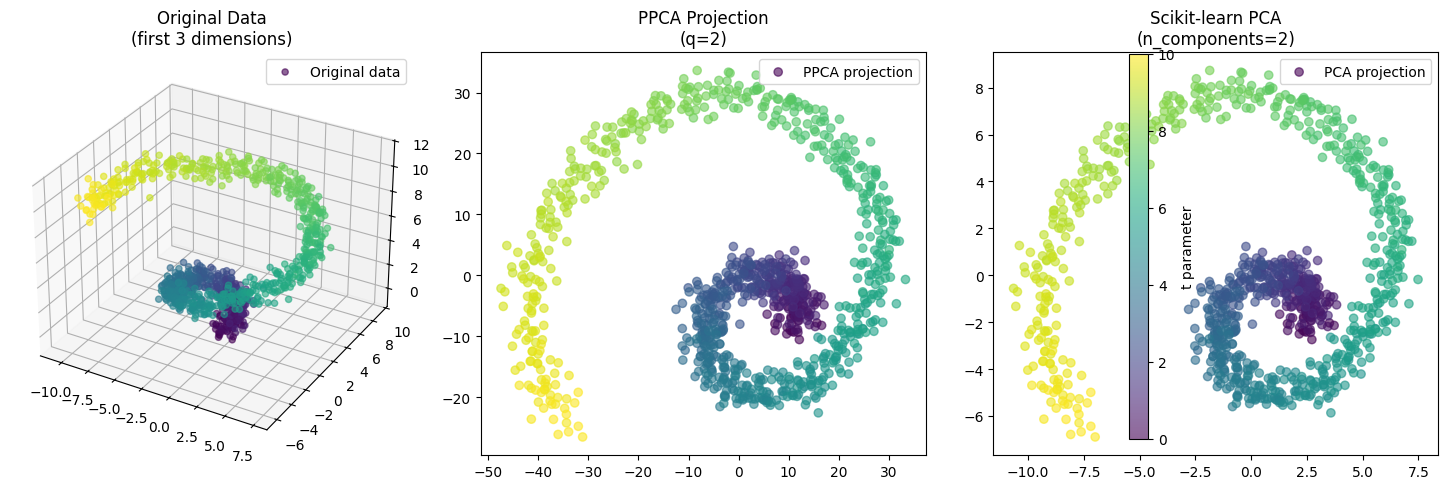

PCA explained variance ratio: [0.47779918 0.357017  ]


In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form
from sklearn.decomposition import PCA

def compare_ppca_pca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data using PPCA
    X_centered = X - X.mean(dim=0)
    X_ppca = X_centered @ W
    
    # Run sklearn PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(131, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='Original data')
    ax1.set_title('Original Data\n(first 3 dimensions)')
    ax1.legend()
    
    # PPCA projection
    ax2 = plt.subplot(132)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PPCA projection')
    ax2.set_title('PPCA Projection\n(q=2)')
    ax2.legend()
    
    # PCA projection
    ax3 = plt.subplot(133)
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PCA projection')
    ax3.set_title('Scikit-learn PCA\n(n_components=2)')
    ax3.legend()
    
    # Add colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3], label='t parameter')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

compare_ppca_pca()

## Test ppca

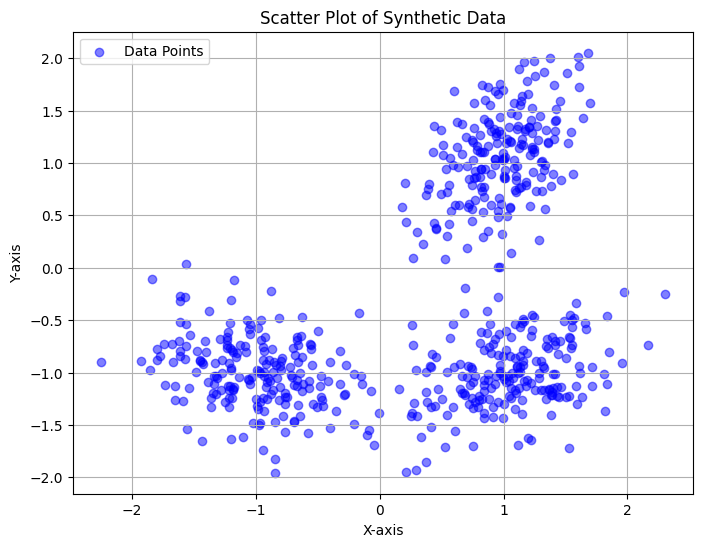

  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 99 iterations with update size 9.857628311783277e-06


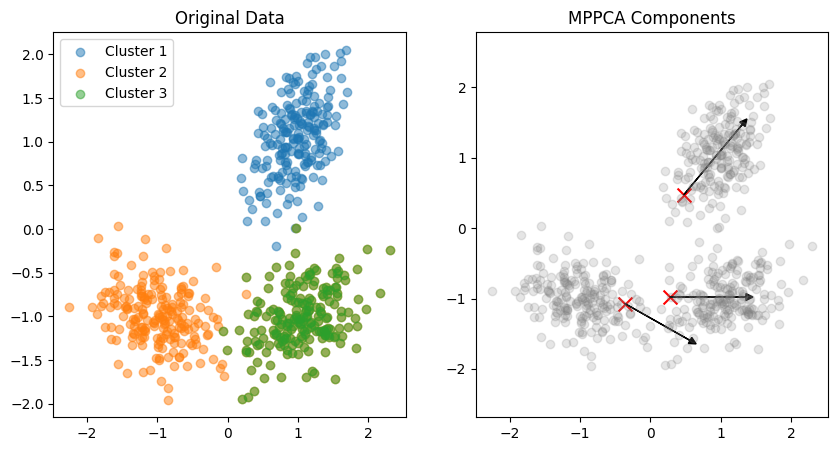

In [ ]:
# synthetic data experiment in 2d
import torch as th
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
th.manual_seed(42)

# Generate synthetic data from 2 Gaussians
n_samples = 200
n_components = 2

# First Gaussian centered at (1,1) with some covariance
mean1 = th.tensor([1.0, 1.0])
cov1 = th.tensor([[0.1, 0.05], [0.05, 0.2]])
samples1 = th.distributions.MultivariateNormal(mean1, cov1).sample((n_samples,))

# Second Gaussian centered at (-1,-1) with different covariance
mean2 = th.tensor([-1.0, -1.0]) 
cov2 = th.tensor([[0.2, -0.05], [-0.05, 0.1]])
samples2 = th.distributions.MultivariateNormal(mean2, cov2).sample((n_samples,))

# third gaussian
mean3 = th.tensor([1.0, -1.0])
cov3 = th.tensor([[0.2, 0.05], [0.05, 0.1]])
samples3 = th.distributions.MultivariateNormal(mean3, cov3).sample((n_samples,))

# Combine the samples
X = th.cat([samples1, samples2, samples3], dim=0)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='blue', label='Data Points')
plt.title('Scatter Plot of Synthetic Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Initialize MPPCA parameters
k = 3  # number of components
d = 2  # data dimension
q = 1  # latent dimension
device = X.device

# Random initialization
W = th.randn(k, d, q).to(device)
mu = th.randn(k, d).to(device)
sigma = th.ones(k).to(device)
pi = th.ones(k).to(device) / k

# Fit MPPCA
W, mu, sigma, pi = mppca(X, q, k, max_iter=100, epsilon=1e-6)

# Visualize results
plt.figure(figsize=(10, 5))

# Plot original data
plt.subplot(121)
plt.scatter(X[:n_samples,0].cpu().numpy(), X[:n_samples,1].cpu().numpy(), alpha=0.5, label='Cluster 1')
plt.scatter(X[n_samples:,0].cpu().numpy(), X[n_samples:,1].cpu().numpy(), alpha=0.5, label='Cluster 2')
plt.scatter(X[2*n_samples:,0].cpu().numpy(), X[2*n_samples:,1].cpu().numpy(), alpha=0.5, label='Cluster 3')
plt.title('Original Data')
plt.legend()

# Plot principal components
plt.subplot(122)
for i in range(k):
    plt.scatter(mu[i,0].cpu().numpy(), mu[i,1].cpu().numpy(), c='red', marker='x', s=100)
    # Plot the principal direction
    direction = W[i,:,0]
    plt.arrow(mu[i,0].cpu().numpy(), mu[i,1].cpu().numpy(), direction[0].cpu().numpy(), direction[1].cpu().numpy(), 
             head_width=0.1, head_length=0.1, fc='k', ec='k')

plt.scatter(X[:,0], X[:,1], alpha=0.2, c='gray')
plt.title('MPPCA Components')
plt.axis('equal')
plt.show()


c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MNIST dataset loaded with shape: (70000, 784)


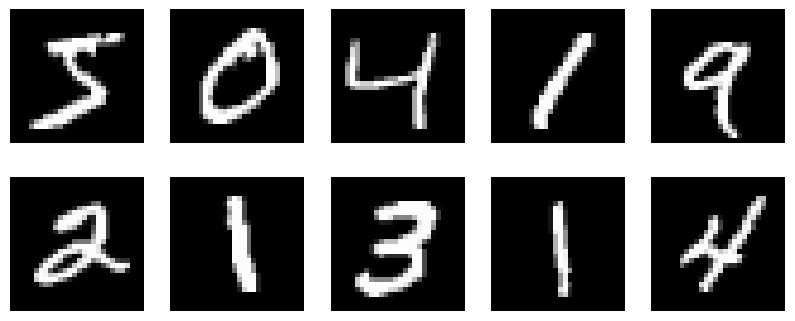

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca


# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
print(f"MNIST dataset loaded with shape: {X.shape}")

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [2]:
import torch as th
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from src.ppca import ppca_closed_form, mppca, compute_Z, compute_responsibilities

import matplotlib.pyplot as plt

device = "cuda" if th.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Convert the MNIST data to a numpy array
X_np = X.values
N = 10000  # Number of samples to use
X_np = X_np[:N]  # Use only the first N samples for faster computation

# Define the number of components for PCA, PPCA, and MPPCA
q_values = [1, 2, 5, 10, 20, 50, 100, 200, 500, 700, 783]
m = 10 # number of components for MPPCA

# Initialize lists to store results
compression_ratios = {'PCA': [], 'PPCA': [], 'MPPCA': []}
reconstruction_errors = {'PCA': [], 'PPCA': [], 'MPPCA': []}

# Calculate the size of the original data
N, d = X_np.shape
original_size = N * d

for q in tqdm(q_values):
    # PCA
    print(f"Running PCA with q={q}...")
    pca = PCA(n_components=q)
    X_pca = pca.fit_transform(X_np)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")   
    X_pca_reconstructed = pca.inverse_transform(X_pca)
    print(f"PCA reconstructed")
    pca_size = N * q + q * d + d
    pca_compression_ratio = pca_size / original_size
    pca_reconstruction_error = np.mean((X_np - X_pca_reconstructed) ** 2)
    
    compression_ratios['PCA'].append(pca_compression_ratio)
    reconstruction_errors['PCA'].append(pca_reconstruction_error)
    
    # PPCA
    print(f"Running PPCA with q={q}...")
    X_th = th.tensor(X_np, dtype=th.float32).to(device)
    W_ppca, sigma_ppca = ppca_closed_form(X_th, q=q, return_sigma=True) # shape : (d, q)
    W_ppca = W_ppca.unsqueeze(0) # shape : (1, d, q)
    sigma_ppca = sigma_ppca.unsqueeze(0) # shape : (1,)
    print(f"PPCA computed")
    mu_ppca = X_th.mean(dim=0).unsqueeze(0) # shape : (1, d)
    Z = compute_Z(W_ppca, X_th, mu_ppca, sigma_ppca, q, device) # Z is of shape (M, N, q)
    X_ppca_reconstructed = (th.einsum("kdq, knq -> knd", W_ppca, Z) + mu_ppca.unsqueeze(1))
    X_ppca_reconstructed = X_ppca_reconstructed.sum(dim=0)
    print(f"PPCA reconstructed")
    ppca_size = N * q + q * d + d + 1
    ppca_compression_ratio = ppca_size / original_size
    ppca_reconstruction_error = th.mean((X_th - X_ppca_reconstructed) ** 2).item()
    
    compression_ratios['PPCA'].append(ppca_compression_ratio)
    reconstruction_errors['PPCA'].append(ppca_reconstruction_error)
    
    # MPPCA
    print(f"Running MPPCA with q={q} and m={m}...")
    W_mppca, mu_mppca, sigma_mppca, pi = mppca(X_th, q=q, k=m)
    # Compute the reconstruction of the data :
    print(f"MPPCA computed")
    X_mppca_reconstructed = th.zeros_like(X_th)
    # Start by computing all latent variables: z^m = M^(-1) W^mT (x - mu^m)
    Z = compute_Z(W_mppca, X_th, mu_mppca, sigma_mppca, q, device) # Z is of shape (M, N, q)
    # Then reconstruct the data using x_n = Sum_M Rnm(W^m z_n^m + mu^m)
    R = compute_responsibilities(X_th, W_mppca, mu_mppca, sigma_mppca, pi, d, device) # R is of shape (M, N)
    X_mppca_reconstructed = (th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1))
    X_mppca_reconstructed = R.unsqueeze(-1) * X_mppca_reconstructed
    X_mppca_reconstructed = X_mppca_reconstructed.sum(dim=0)
    print(f"MPPCA reconstructed")
    mppca_size = m * (N * q + q * d + d + 1)
    mppca_compression_ratio = mppca_size / original_size
    mppca_reconstruction_error = th.mean((X_th - X_mppca_reconstructed) ** 2).item()
    
    compression_ratios['MPPCA'].append(mppca_compression_ratio)
    reconstruction_errors['MPPCA'].append(mppca_reconstruction_error)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(compression_ratios['PCA'], reconstruction_errors['PCA'], label='PCA', marker='o')
plt.plot(compression_ratios['PPCA'], reconstruction_errors['PPCA'], label='PPCA', marker='o')
plt.plot(compression_ratios['MPPCA'], reconstruction_errors['MPPCA'], label='MPPCA', marker='o')
plt.xlabel('Compression Ratio')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Compression Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Plot with log scale on y-axis
plt.figure(figsize=(10, 6))
plt.plot(compression_ratios['PCA'], reconstruction_errors['PCA'], label='PCA', marker='o')
plt.plot(compression_ratios['PPCA'], reconstruction_errors['PPCA'], label='PPCA', marker='o')
plt.plot(compression_ratios['MPPCA'], reconstruction_errors['MPPCA'], label='MPPCA', marker='o')
plt.xlabel('Compression Ratio')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Compression Ratio')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Using device: cuda


  0%|          | 0/11 [00:00<?, ?it/s]

Running PCA with q=1...
Explained variance ratio: 0.10
PCA reconstructed
Running PPCA with q=1...
PPCA computed
PPCA reconstructed
Running MPPCA with q=1 and m=10...


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Finished in 99 iterations with update size 0.0065892112902997575
MPPCA computed
MPPCA reconstructed


  9%|▉         | 1/11 [02:24<24:04, 144.41s/it]

Running PCA with q=2...
Explained variance ratio: 0.17
PCA reconstructed
Running PPCA with q=2...
PPCA computed
PPCA reconstructed
Running MPPCA with q=2 and m=10...


100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


Finished in 99 iterations with update size 0.0021930950625070854
MPPCA computed
MPPCA reconstructed


 18%|█▊        | 2/11 [04:50<21:48, 145.35s/it]

Running PCA with q=5...
Explained variance ratio: 0.34
PCA reconstructed
Running PPCA with q=5...
PPCA computed
PPCA reconstructed
Running MPPCA with q=5 and m=10...


 42%|████▏     | 42/100 [01:02<01:26,  1.50s/it]


Finished in 42 iterations with update size 1.61530671432524e-05
MPPCA computed
MPPCA reconstructed


 27%|██▋       | 3/11 [05:55<14:28, 108.59s/it]

Running PCA with q=10...
Explained variance ratio: 0.49
PCA reconstructed
Running PPCA with q=10...
PPCA computed
PPCA reconstructed
Running MPPCA with q=10 and m=10...


 48%|████▊     | 48/100 [01:14<01:21,  1.56s/it]


Finished in 48 iterations with update size 1.703646324744389e-09
MPPCA computed
MPPCA reconstructed


 36%|███▋      | 4/11 [07:12<11:12, 96.04s/it] 

Running PCA with q=20...
Explained variance ratio: 0.65
PCA reconstructed
Running PPCA with q=20...
PPCA computed
PPCA reconstructed
Running MPPCA with q=20 and m=10...


 55%|█████▌    | 55/100 [01:26<01:10,  1.57s/it]


Finished in 55 iterations with update size 5.7636130528796133e-08
MPPCA computed
MPPCA reconstructed


 45%|████▌     | 5/11 [08:40<09:20, 93.35s/it]

Running PCA with q=50...
Explained variance ratio: 0.83
PCA reconstructed
Running PPCA with q=50...
PPCA computed
PPCA reconstructed
Running MPPCA with q=50 and m=10...


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]


Finished in 30 iterations with update size 1.481354538909017e-06
MPPCA computed
MPPCA reconstructed


 55%|█████▍    | 6/11 [09:32<06:35, 79.16s/it]

Running PCA with q=100...
Explained variance ratio: 0.92
PCA reconstructed
Running PPCA with q=100...
PPCA computed
PPCA reconstructed
Running MPPCA with q=100 and m=10...


 53%|█████▎    | 53/100 [01:30<01:19,  1.70s/it]


Finished in 53 iterations with update size 1.6100702400823497e-23
MPPCA computed
MPPCA reconstructed


 64%|██████▎   | 7/11 [11:04<05:33, 83.47s/it]

Running PCA with q=200...
Explained variance ratio: 0.97
PCA reconstructed
Running PPCA with q=200...
PPCA computed
PPCA reconstructed
Running MPPCA with q=200 and m=10...


 32%|███▏      | 32/100 [00:53<01:53,  1.67s/it]


Finished in 32 iterations with update size 1.2569823893995196e-13
MPPCA computed
MPPCA reconstructed


 73%|███████▎  | 8/11 [12:00<03:44, 74.76s/it]

Running PCA with q=500...
Explained variance ratio: 1.00
PCA reconstructed
Running PPCA with q=500...
PPCA computed
PPCA reconstructed
Running MPPCA with q=500 and m=10...


 73%|███████▎  | 8/11 [12:03<04:31, 90.44s/it]


_LinAlgError: linalg.inv: (Batch element 2): The diagonal element 498 is zero, the inversion could not be completed because the input matrix is singular.

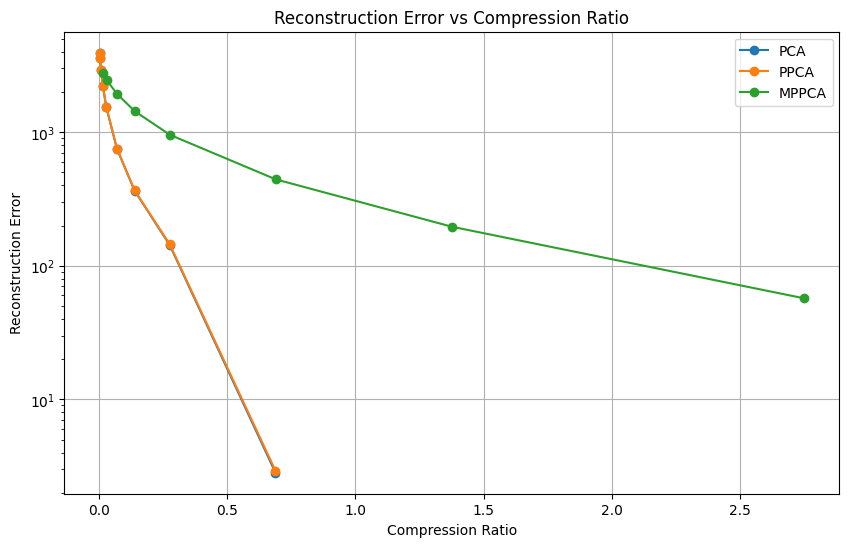

In [3]:

# Plot with log scale on y-axis
plt.figure(figsize=(10, 6))
plt.plot(compression_ratios['PCA'], reconstruction_errors['PCA'], label='PCA', marker='o')
plt.plot(compression_ratios['PPCA'], reconstruction_errors['PPCA'], label='PPCA', marker='o')
plt.plot(compression_ratios['MPPCA'], reconstruction_errors['MPPCA'], label='MPPCA', marker='o')
plt.xlabel('Compression Ratio')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Compression Ratio')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()